In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-09-19 08:54:26,609	INFO worker.py:1636 -- Started a local Ray instance.


0.1 0.005018897251342104 arcsec / pix


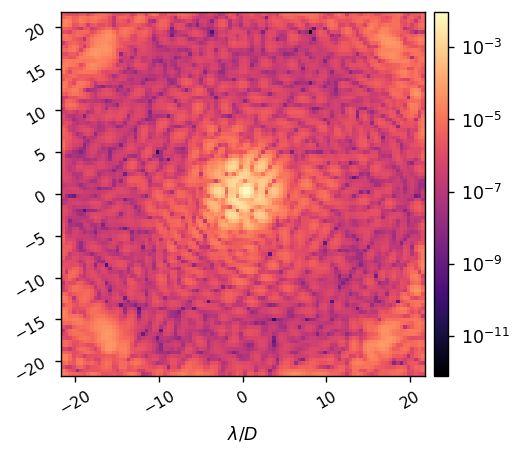

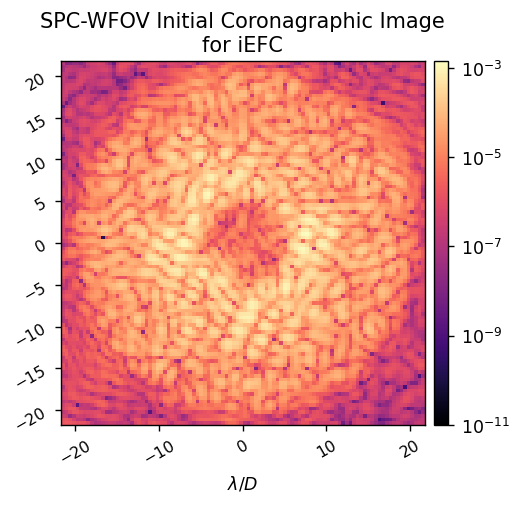

In [2]:
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide_band1', npsf=100,
                                  use_pupil_defocus=True, 
                                  use_opds=True)
mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im = mode.snap()
imshow1(ref_im, 'SPC-WFOV Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

# Create dark hole ROI to calibrate and control

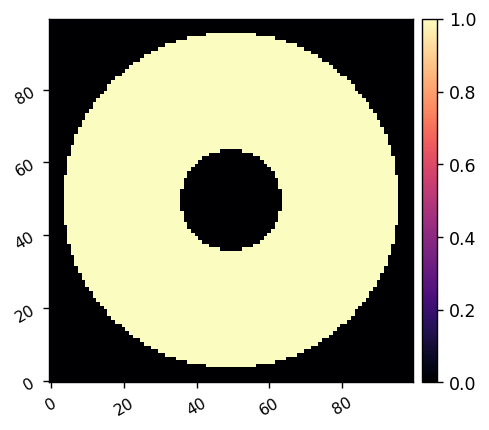

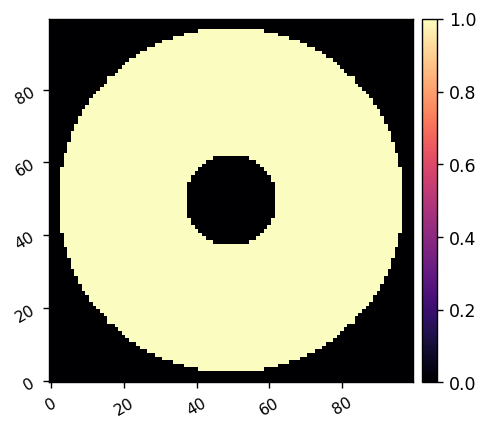

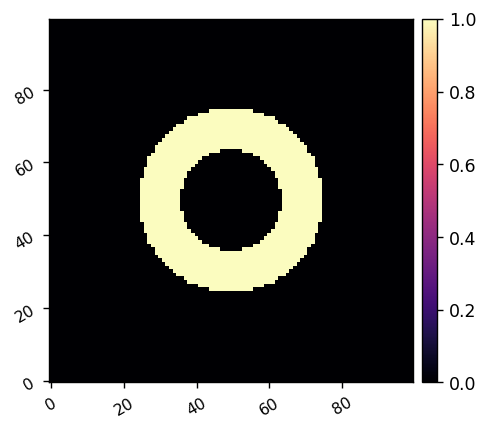

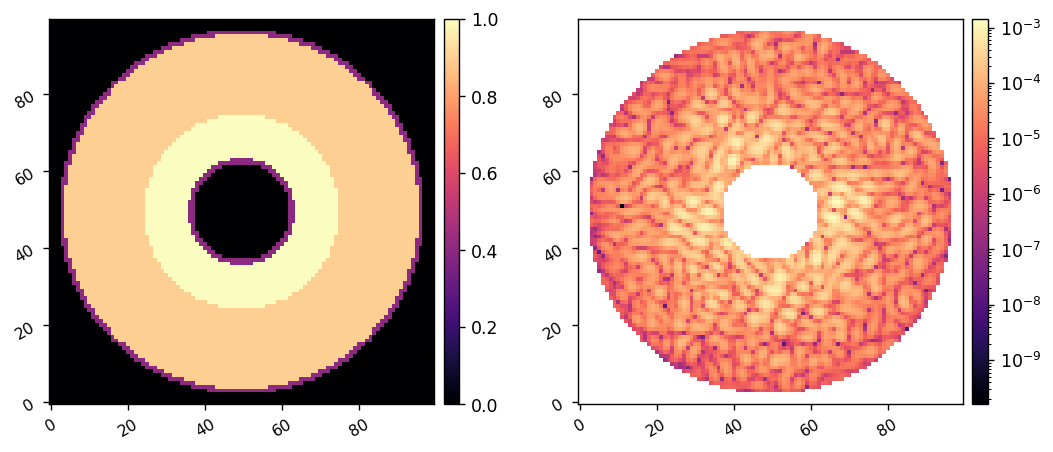

7.522976779629886e-05


In [3]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=20, edge=None, plot=True)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=11, edge=None, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

# Create calibration and probe modes

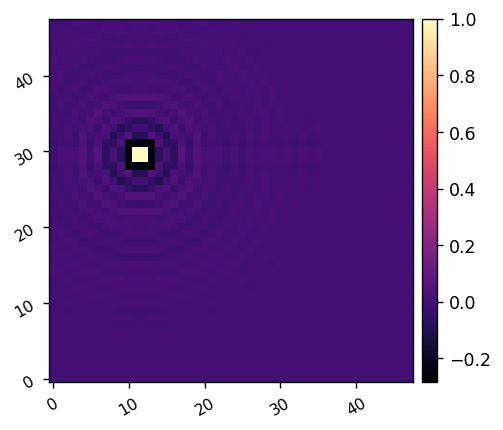

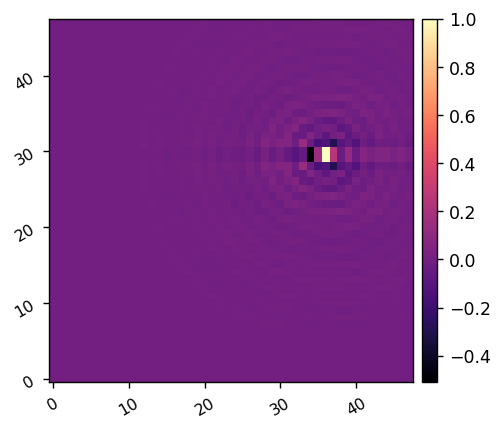

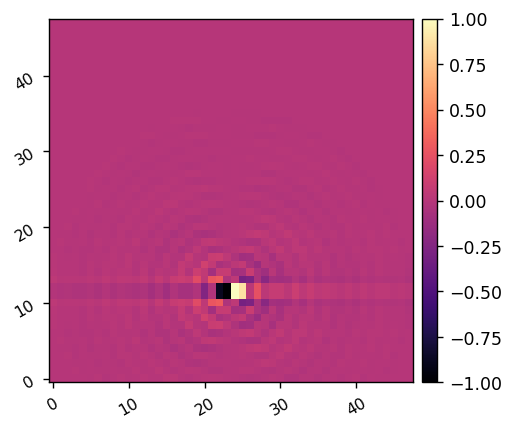

In [6]:
reload(utils)
probe_amp = 2e-8
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.2, shift=[(-12,6), (12,6), (0,-12)], nprobes=3, plot=True)
# probe_modes = probe_modes[:2]


In [ ]:
probe

In [5]:
probe_modes.shape

(2, 48, 48)

(4096, 4608)


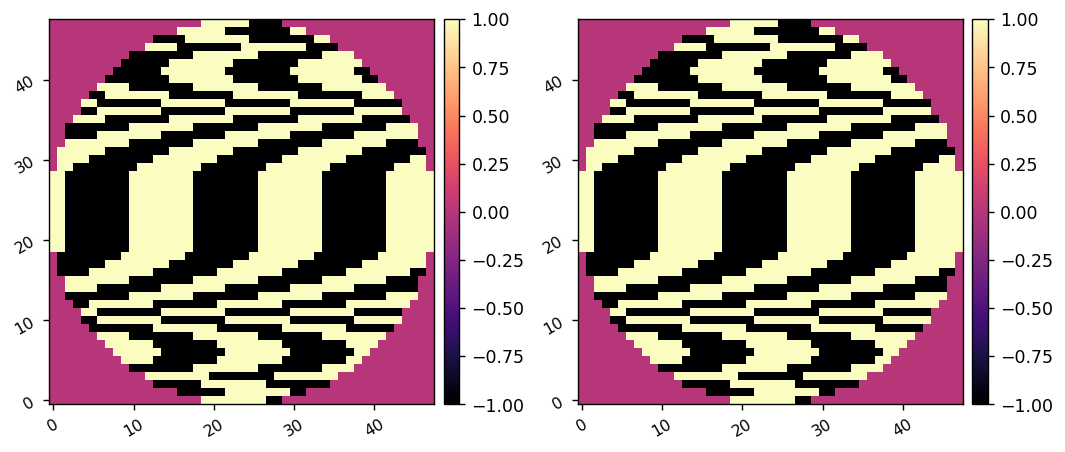

In [7]:
calib_modes = utils.create_all_poke_modes(mode.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 8
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i+Nhad,mode.Nact**2:].reshape(mode.Nact,mode.Nact))


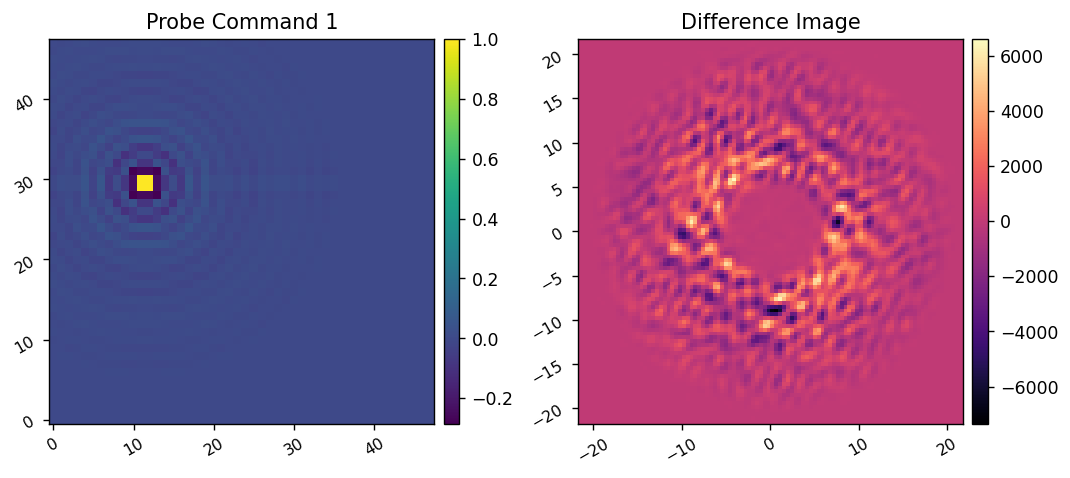

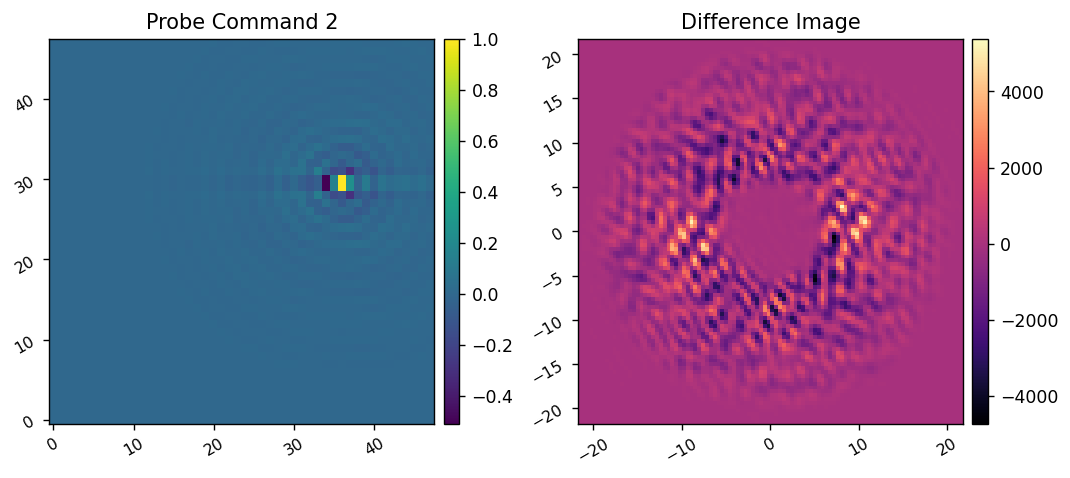

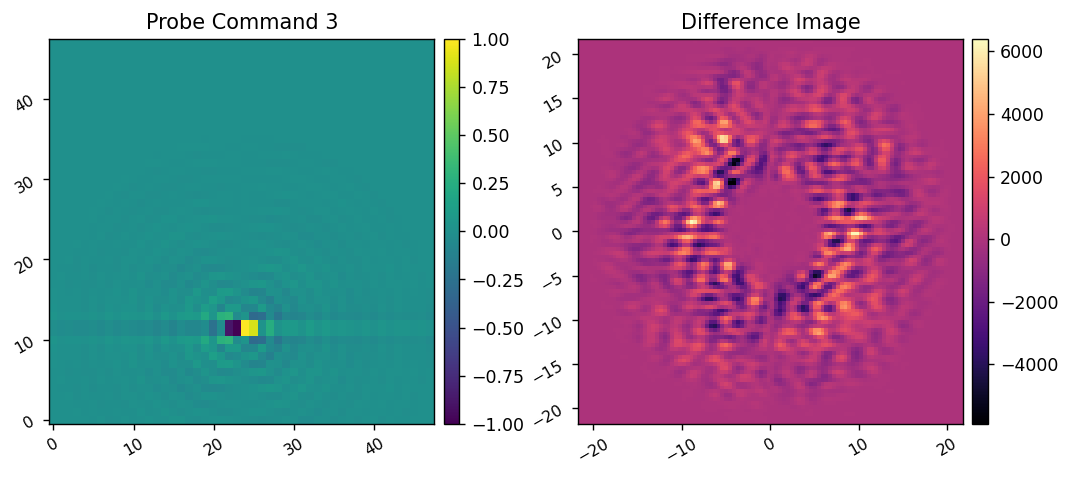

In [8]:
reload(iefc_2dm)

differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
ims = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)

In [15]:
2.3*4096/3600

2.6168888888888886

Calibrating iEFC...
	Calibrated mode 2/2 in 4.611s
Calibration complete.


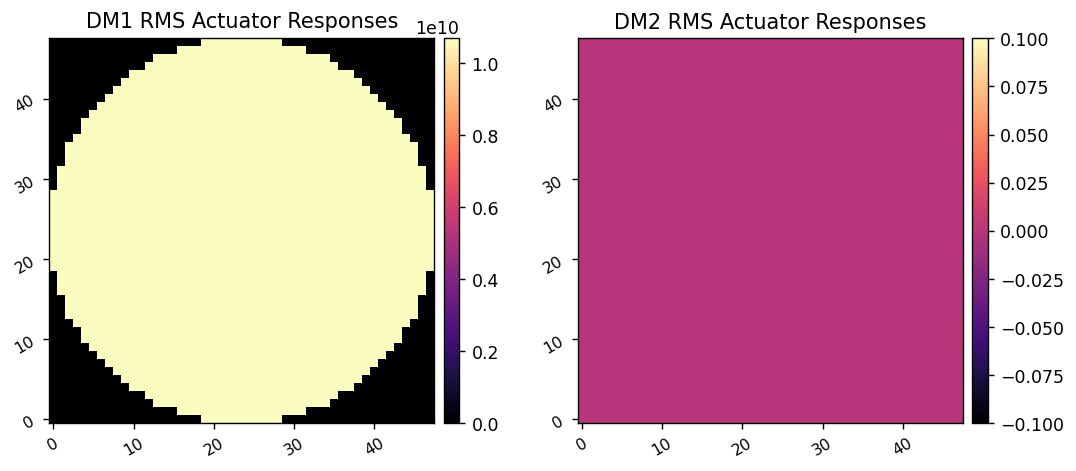

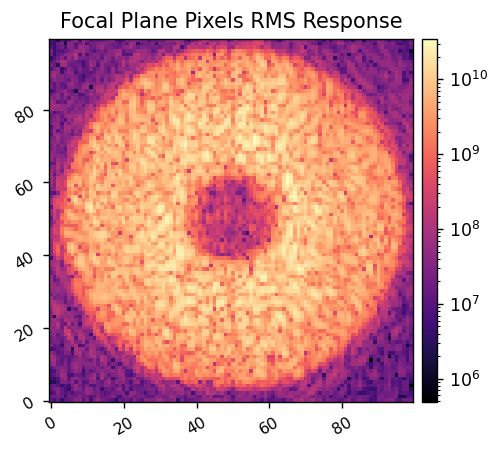

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_matrix_20230912.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_cube_20230912.fits


In [13]:
reload(iefc_2dm)

calib_amp = 5e-9

response_matrix, response_cube = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                     calib_amp, calib_modes[:2], 
                                                     return_all=True, 
#                                                     plot_responses=False,
                                                   )

utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


In [9]:
# date = 20230630
# date = 20230703
# date = 20230713
# date = 20230720
# date = 20230723
# date = 20230804
# date = 20230806
# date = 20230808
# response_matrix = xp.array(fits.getdata(response_dir/f'bbspc_iefc_2dm_poke_response_matrix_{date}.fits'))
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'bbspc_iefc_2dm_poke_response_cube_{date}.fits'))

# date = 20230809
# response_matrix = xp.array(fits.getdata(response_dir/f'bbspc_iefc_2dm_had_response_matrix_{date}.fits'))
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'bbspc_iefc_2dm_had_response_cube_{date}.fits'))

date = 20230912
date = 20230913
date = 20230918
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_575_had_modes_response_matrix_{date}.fits'))
response_cube = xp.array(fits.getdata(data_dir/response_dir/f'spc_wide_575_had_modes_response_cube_{date}.fits'))

In [19]:
utils.fourier_filter_command()

<function utils.fourier_filter_command(command, iwa, owa)>

# Run IEFC

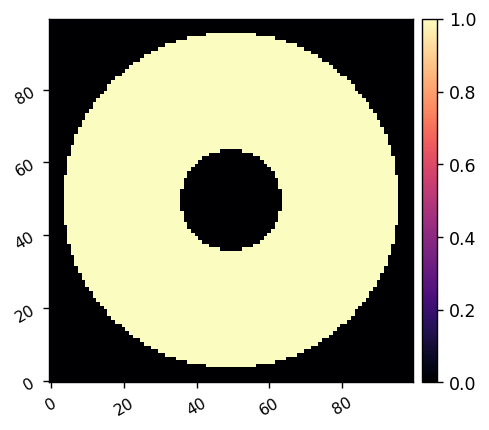

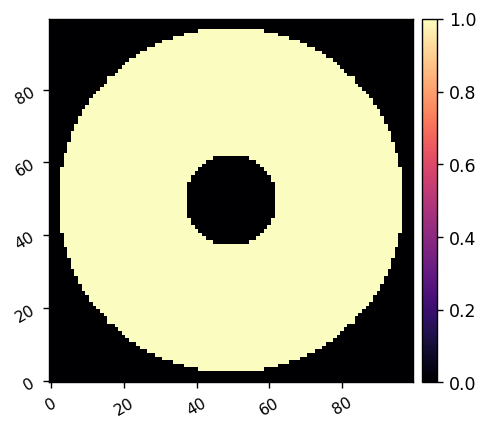

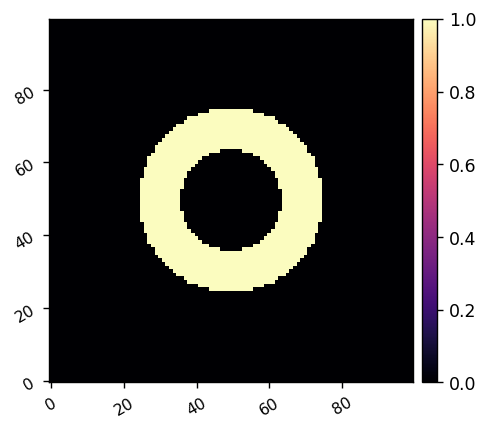

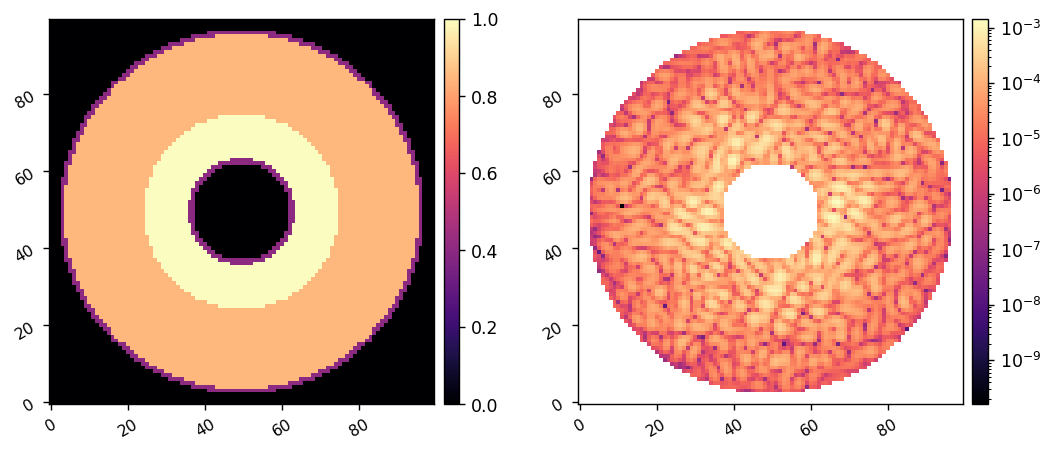

7.522976779629886e-05


In [23]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=20, edge=None, plot=True)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=11, edge=None, plot=True)

relative_weight_1 = 0.85
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

In [39]:
mode.reset_dms()

In [10]:
images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])

In [32]:
dm1_commands[-8].shape

(48, 48)

In [33]:
mode.set_dm1(ensure_np_array(dm1_commands[-8]))
mode.set_dm2(ensure_np_array(dm2_commands[-8]))

In [26]:
reg_cond = 1e-1
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])


Running iEFC...
	Closed-loop iteration 36 / 41
	Mean NI of this iteration: 6.388e-08


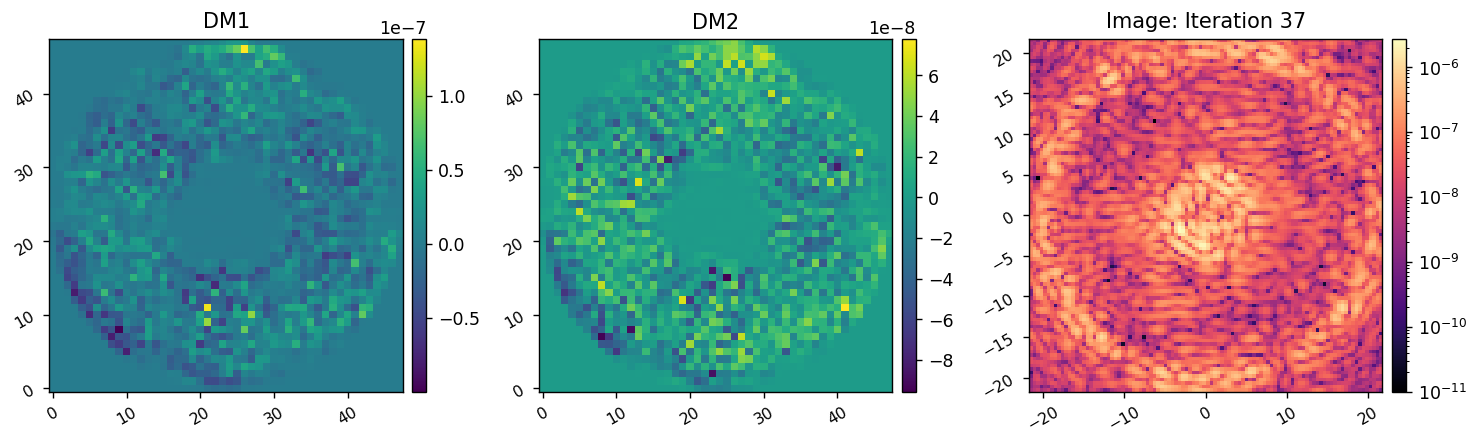

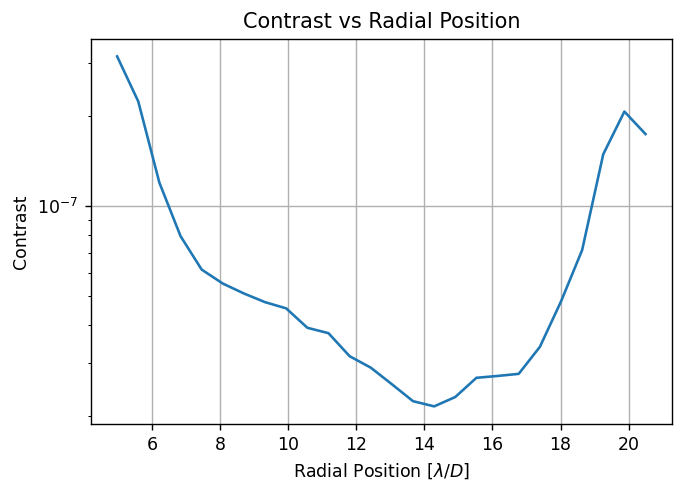

	Closed-loop iteration 37 / 41
	Mean NI of this iteration: 6.328e-08


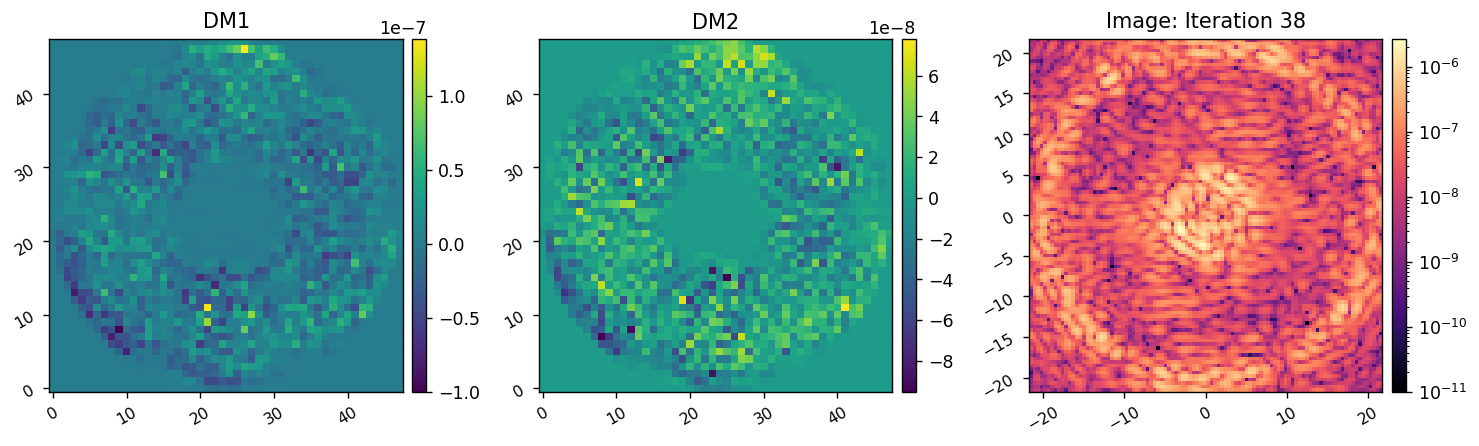

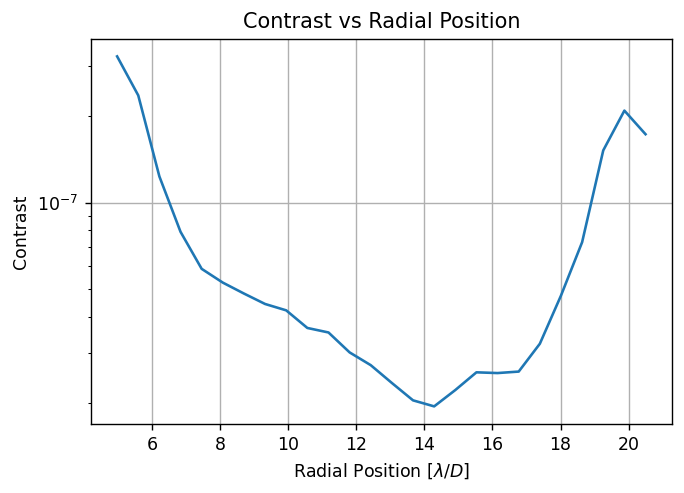

	Closed-loop iteration 38 / 41
	Mean NI of this iteration: 6.334e-08


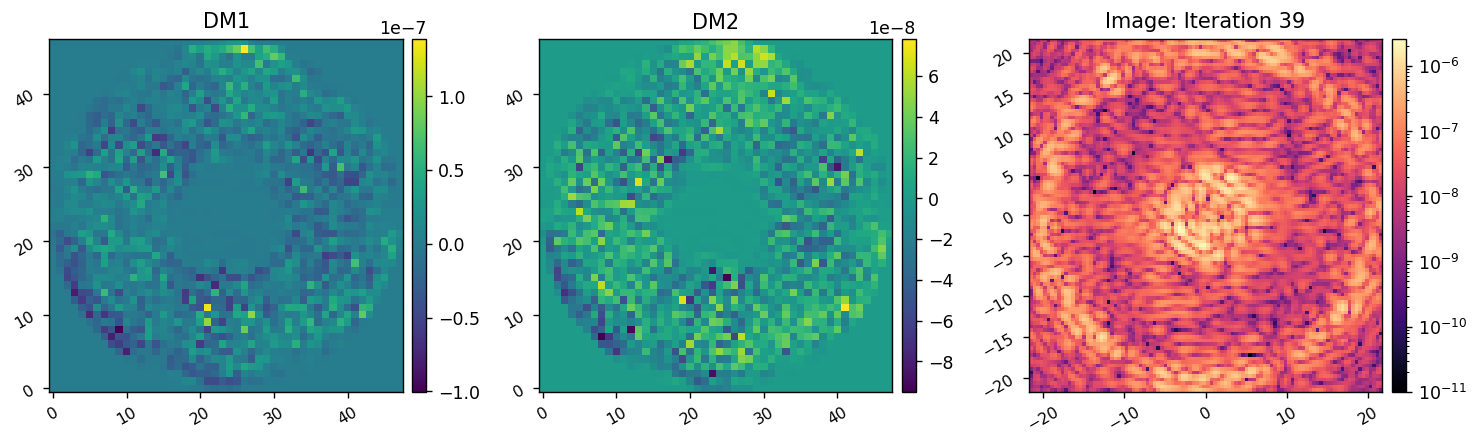

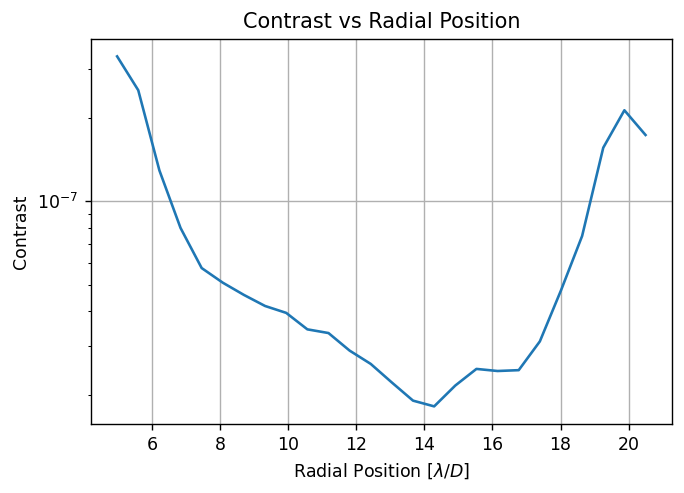

	Closed-loop iteration 39 / 41
	Mean NI of this iteration: 6.373e-08


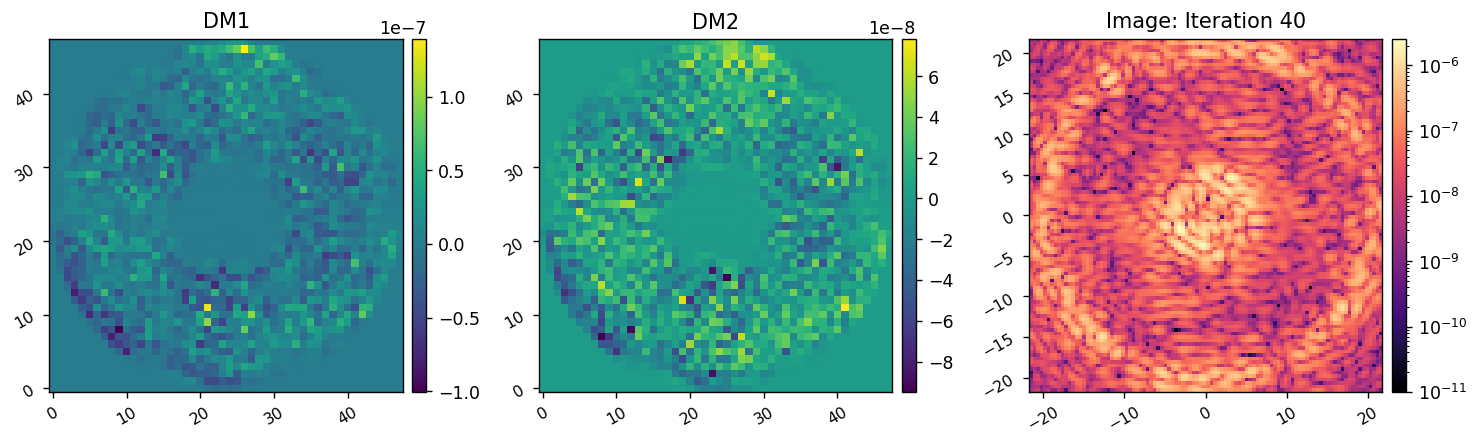

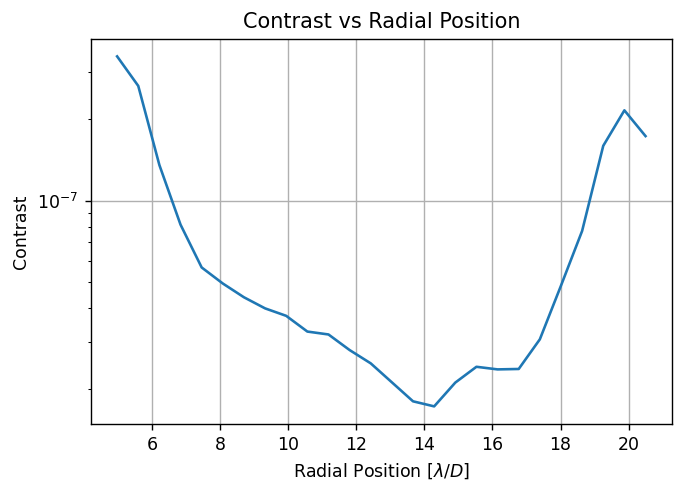

	Closed-loop iteration 40 / 41
	Mean NI of this iteration: 6.435e-08


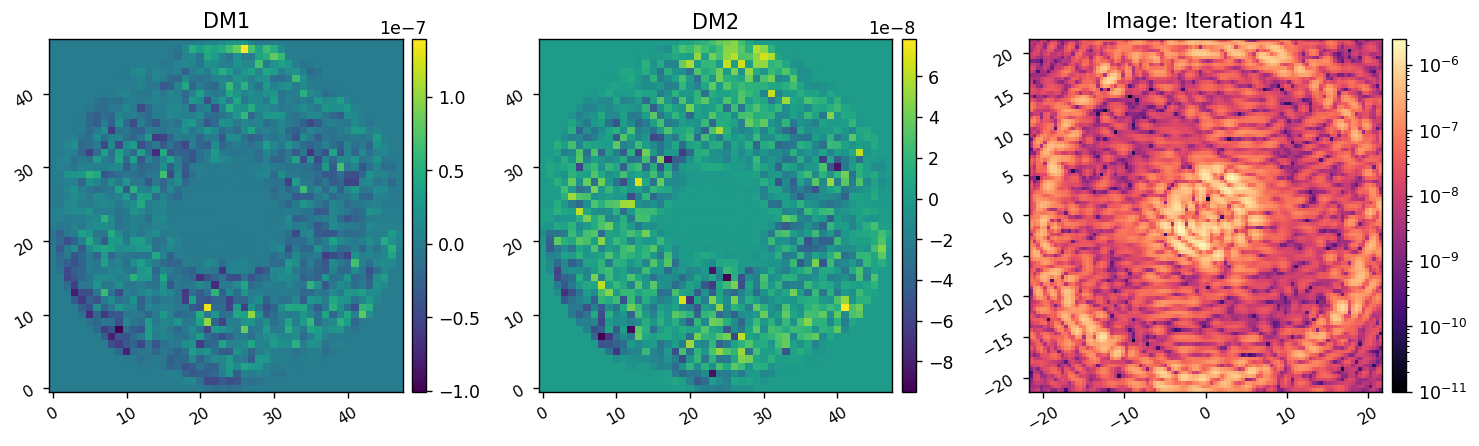

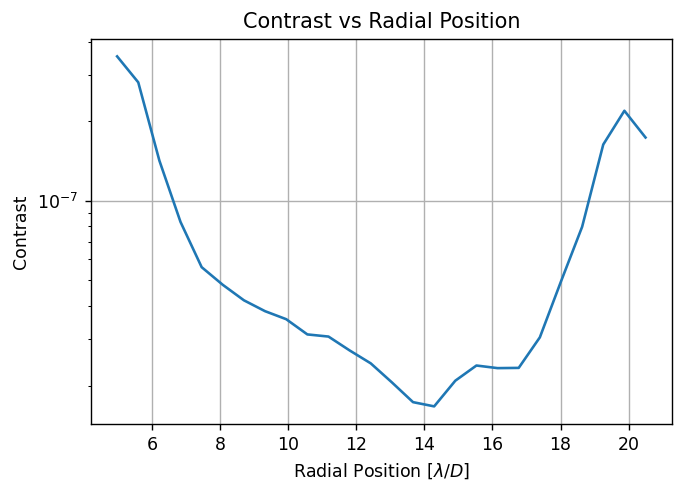

Closed loop for given control matrix completed in 14.658s.


In [34]:
reload(iefc_2dm)
reload(utils)

images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                          control_matrix,
                                          probe_modes, 
                                          probe_amp, 
                                          calib_modes,
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0,
#                                                   use_fourier_filter=True,
                                          plot_all=True,
                                         plot_radial_contrast=True,
                                                  old_images=images,
                                                  old_dm1_commands=dm1_commands,
                                                  old_dm2_commands=dm2_commands,
                                         )